In [1]:
import itertools
from typing import Literal

import matplotlib.pyplot as plt
import nrrd
import numpy as np
from scipy import ndimage
from scipy.spatial.transform import Rotation
import vedo

from histalign.backend.models import Orientation

vedo.settings.default_backend = "vtk"

In [60]:
axes = [
    vedo.Arrow(end_pt=(1, 0, 0), c="red", s=0.001),
    vedo.Arrow(end_pt=(0, 1, 0), c="yellow", s=0.001),
    vedo.Arrow(end_pt=(0, 0, 1), c="blue", s=0.001),
]


def compute_brightest(image: np.ndarray) -> tuple[int, ...]:
    maximum = np.max(image)
    if maximum == 0:
        print("WARNING: No maximum found")
    elif np.sum(image == maximum) > 1:
        print("WARNING: More than one max detected")

    return tuple(map(int, np.unravel_index(np.argmax(image), image.shape)))


def compute_camera(
    orientation: Orientation, focal_point: np.ndarray, distance: int
) -> dict:
    match orientation:
        case Orientation.CORONAL:
            camera = dict(
                position=focal_point + np.array([distance, 0, 0]),
                focal_point=focal_point,
                viewup=(0, -1, 0),
            )
        case Orientation.HORIZONTAL:
            camera = dict(
                position=focal_point + np.array([0, -distance, 0]),
                focal_point=focal_point,
                viewup=(-1, 0, 0),
            )
        case Orientation.SAGITTAL:
            camera = dict(
                position=focal_point + np.array([0, 0, -distance]),
                focal_point=focal_point,
                viewup=(0, -1, 0),
            )
        case other:
            raise Exception(f"ASSERT NOT REACHED: {other}")

    return camera


def compute_origin(
    centre: list[int], offset: int, orientation: Orientation.CORONAL
) -> list[int]:
    match orientation:
        case Orientation.CORONAL:
            origin = [centre[0] + offset, centre[1], centre[2]]
        case Orientation.HORIZONTAL:
            origin = [centre[0], centre[1] + offset, centre[2]]
        case Orientation.SAGITTAL:
            origin = [centre[0], centre[1], centre[2] + offset]
        case other:
            raise Exception(f"ASSERT NOT REACHED: {other}")

    return origin


def compute_mesh_centre(mesh: vedo.Mesh) -> np.ndarray:
    bounds = mesh.metadata["original_bounds"]

    return np.array(
        [
            (bounds[1] + bounds[0]) // 2,
            (bounds[3] + bounds[2]) // 2,
            (bounds[5] + bounds[4]) // 2,
        ]
    )


def compute_normal(pitch: int, yaw: int, orientation: Orientation) -> np.array:
    match orientation:
        case Orientation.CORONAL:
            normal = [1, 0, 0]
            rotation = Rotation.from_euler("ZY", [pitch, yaw], degrees=True)
        case Orientation.HORIZONTAL:
            normal = [0, 1, 0]
            rotation = Rotation.from_euler("ZX", [pitch, yaw], degrees=True)
        case Orientation.SAGITTAL:
            normal = [0, 0, 1]
            rotation = Rotation.from_euler("XY", [pitch, yaw], degrees=True)
        case other:
            raise Exception(f"ASSERT NOT REACHED: {other}")

    return rotation.apply(normal).reshape(3)


def imshow(
    image: np.ndarray,
    title: str = "",
    figsize: tuple[int, int] | None = None,
    save: bool = False,
) -> None:
    plt.figure(figsize=figsize)
    plt.suptitle(title)

    plt.axis(False)
    plt.imshow(image)

    if save:
        plt.imsave(f"{title}.png", image)
    plt.show()


def slice_volume(
    volume: vedo.Volume,
    origin: list[int],
    normal: np.ndarray,
    pitch: int,
    orientation: Orientation,
    interpolation: Literal["nearest", "linear", "cubic"] = "cubic",
) -> np.ndarray:
    # Get the vedo plane
    plane_mesh = volume.slice_plane(
        origin=origin,
        normal=normal.tolist(),
        autocrop=True,
        mode=interpolation,
    )

    # When working with an offset and pitch/yaw, the way in which
    # vedo slices the volumes causes the returned mesh centre to
    # be offset from the origin. To correct that, we need to pad
    # the image.
    mesh_centre = compute_mesh_centre(plane_mesh)

    if (padding := mesh_centre[1]) > 0:
        i_padding = (int(round(2 * padding)), 0)
    else:
        i_padding = (0, int(round(2 * -padding)))

    if (padding := mesh_centre[0]) > 0:
        j_padding = (int(round(2 * padding)), 0)
    else:
        j_padding = (0, int(round(2 * -padding)))

    # Convert the plane to an array
    plane_array = plane_mesh.pointdata["ImageScalars"].reshape(
        plane_mesh.metadata["shape"]
    )
    plane_array = np.pad(plane_array, (i_padding, j_padding))

    # Correct vedo-specific rotations and apply somee custom rotations for presenting
    if orientation == Orientation.CORONAL:
        # Correct the vedo rotation so that superior is at the top and anterior is at
        # the bottom.
        plane_array = ndimage.rotate(plane_array, pitch, reshape=True)
        # Flip left-right so that the left hemisphere is on the left
        plane_array = np.fliplr(plane_array)
    elif orientation == Orientation.HORIZONTAL:
        # Correct the vedo rotation and apply own so that anterior is at the top and
        # posterior is at the bottom.
        plane_array = ndimage.rotate(plane_array, pitch - 90, reshape=True)

    return plane_array

In [3]:
orientation = Orientation.HORIZONTAL

plotter = vedo.Plotter(axes=4)

normal = compute_normal(0, 0, orientation)

pitch = 0
yaw = 0
rotated_normal = compute_normal(pitch, yaw, orientation)
# pitch = 35
# yaw = 0
# rotated_normal = compute_normal(pitch, yaw, orientation)
# pitch = 0
# yaw = 35
# rotated_normal = compute_normal(pitch, yaw, orientation)
# pitch = 35
# yaw = 35
# rotated_normal = compute_normal(pitch, yaw, orientation)

plotter += vedo.Arrow((0, 0, 0), normal, c="red")
plotter += vedo.Arrow((0, 0, 0), rotated_normal, c="blue")
plotter += vedo.Plane((0, 0, 0), normal=rotated_normal)

plotter.show(
    camera=compute_camera(orientation, (0, 0, 0), 10), interactive=False
).interactive().close()

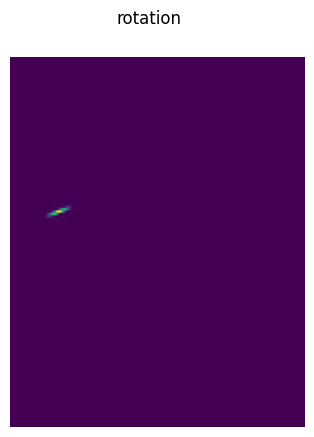

In [4]:
array = np.zeros((132, 80, 114), np.uint8)
array[40, :, 50] = 255
# array[array.shape[0] // 2, array.shape[1] // 2, array.shape[2] // 2] = 255
volume = vedo.Volume(array)

orientation = Orientation.HORIZONTAL

pitch = 20
yaw = 80
offset = 0

normal = compute_normal(pitch, yaw, orientation)

centre = np.floor(np.array(array.shape) // 2)
origin = compute_origin(centre, offset, orientation)

image = slice_volume(volume, origin, normal, pitch, orientation)
imshow(image, save=True, title="rotation")

In [5]:
# Assume image centre is the same as the plane origin (mostly is)
image_centre_position = np.array(image.shape) // 2

# Get pixel position
# image_position = (62, 55)  # WxH
# image_position = image_position[::-1]  # IxJ
image_position = compute_brightest(image)

# Relative pixel position from image centre
relative_image_position = [
    image_position[0] - image_centre_position[0],
    image_position[1] - image_centre_position[1],
]
# Convert to non-rotated coordinates from centre
image_coordinates = [
    relative_image_position[0],
    0,
    relative_image_position[1],
]

# Apply rotation
rotation = Rotation.from_euler("ZX", [pitch, yaw], degrees=True)
rotated_coordinates = rotation.apply(image_coordinates)

# Add origin
volume_coordinates = origin + rotated_coordinates
print(volume_coordinates)

# Error
volume_coordinates = np.floor(volume_coordinates)
error = np.sqrt((volume_coordinates[0] - 40) ** 2 + (volume_coordinates[2] - 50) ** 2)
error

[40.31103238 72.57040127 50.05407289]


0.0

In [6]:
plotter = vedo.Plotter(axes=4)

plotter += vedo.Line((40, 0, 50), (40, 80, 50), c="purple")

plotter += vedo.Arrow(origin, np.array(origin) + rotated_coordinates, c="blue", s=0.2)

plotter += vedo.Plane(origin, normal, s=(131, 137))

plotter.show(
    camera=compute_camera(orientation, origin, 200), interactive=False
).interactive().close()

### Compute error for various pitch and yaw

In [ ]:
array = np.zeros((132, 80, 114), np.uint8)
array[40, :, 50] = 255
volume = vedo.Volume(array)

orientation = Orientation.HORIZONTAL


for pitch, yaw in itertools.product(range(0, 90, 5), range(0, 90, 5)):
    offset = 0

    normal = compute_normal(pitch, yaw, orientation)

    centre = np.floor(np.array(array.shape) // 2)
    origin = compute_origin(centre, offset, orientation)

    image = slice_volume(volume, origin, normal, pitch, orientation)

    # Assume image centre is the same as the plane origin (mostly is)
    image_centre_position = np.array(image.shape) // 2

    # Get pixel position
    # image_position = (62, 55)  # WxH
    # image_position = image_position[::-1]  # IxJ
    image_position = compute_brightest(image)
    if image_position == (0, 0):
        continue

    # Relative pixel position from image centre
    relative_image_position = [
        image_position[0] - image_centre_position[0],
        image_position[1] - image_centre_position[1],
    ]
    # Convert to non-rotated coordinates from centre
    image_coordinates = [
        relative_image_position[0],
        0,
        relative_image_position[1],
    ]

    # Apply rotation
    rotation = Rotation.from_euler("ZX", [pitch, yaw], degrees=True)
    rotated_coordinates = rotation.apply(image_coordinates)

    # Add origin
    volume_coordinates = origin + rotated_coordinates

    # Error
    volume_coordinates = np.floor(volume_coordinates)
    error = np.sqrt(
        (volume_coordinates[0] - 40) ** 2 + (volume_coordinates[2] - 50) ** 2
    )

    if error > 5:
        print(
            f"Pitch: {pitch}  -  Yaw: {yaw}  -  Coordinates: {volume_coordinates}  -  Error: {error}"
        )

In [30]:
array = np.zeros((132, 80, 114), np.uint8)
array[40, :, 50] = 255
volume = vedo.Volume(array)

orientation = Orientation.HORIZONTAL

pitch = 0
yaw = 45
offset = 50

normal = compute_normal(pitch, yaw, orientation)

centre = np.floor(np.array(array.shape) // 2)
origin = compute_origin(centre, offset, orientation)
print(origin)

image = slice_volume(volume, origin, normal, pitch, orientation)
# imshow(image)

# Assume image centre is the same as the plane origin (mostly is)
image_centre_position = np.array(image.shape) // 2

# Get pixel position
image_position = compute_brightest(image)
print(image_position)

# Relative pixel position from image centre
relative_image_position = [
    image_position[0] - image_centre_position[0],
    image_position[1] - image_centre_position[1],
]
# Convert to non-rotated coordinates from centre
image_coordinates = [
    relative_image_position[0],
    0,
    relative_image_position[1],
]

# Apply rotation
rotation = Rotation.from_euler("ZX", [pitch, yaw], degrees=True)
rotated_coordinates = rotation.apply(image_coordinates)

# # Apply offset
# rotated_coordinates[1] += offset

# Add origin
volume_coordinates = origin + rotated_coordinates

# Error
volume_coordinates = np.floor(volume_coordinates)
error = np.sqrt((volume_coordinates[0] - 40) ** 2 + (volume_coordinates[2] - 50) ** 2)

print(
    f"Pitch: {pitch}  -  Yaw: {yaw}  -  Coordinates: {volume_coordinates}  -  Error: {error}"
)

plotter = vedo.Plotter(axes=4)

plotter += vedo.Line((40, 0, 50), (40, 80, 50), c="purple")

plotter += vedo.Arrow(origin, origin + rotated_coordinates, c="red", s=0.2)
plotter += vedo.Arrow((0, 0, 0), np.array(volume_coordinates), c="blue", s=0.2)

plotter += vedo.Plane(origin, compute_normal(pitch, yaw, orientation), s=(131, 137))

plotter.show(
    camera=compute_camera(orientation, origin, 200), interactive=False
).interactive().close()

[66.0, 90.0, 57.0]
(0, 0)
Pitch: 0  -  Yaw: 45  -  Coordinates: [  0. 123.  23.]  -  Error: 48.25971404805462


origin=[66.0, 40.0, 57.0]
image_position=(52, 61)
relative_image_position=[-27, -8]
Pitch: 20  -  Yaw: 40  -  Coordinates: [38. 35. 50.]  -  Error: 2.0


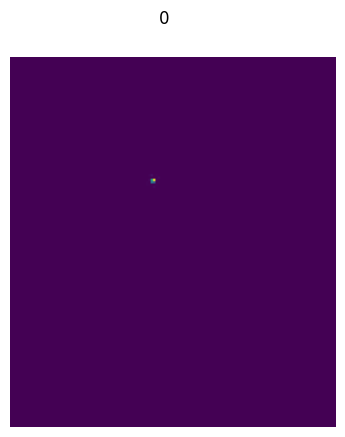

origin=[66.0, 70.0, 57.0]
image_position=(63, 80)
relative_image_position=[-26, -9]
Pitch: 20  -  Yaw: 40  -  Coordinates: [39. 66. 50.]  -  Error: 1.0


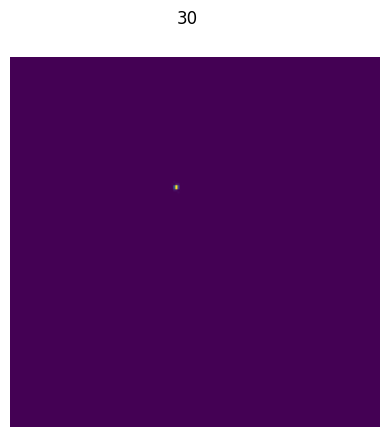

In [63]:
array = np.zeros((132, 80, 114), np.uint8)
array[40, :, 50] = 255
volume = vedo.Volume(array)

plotter = vedo.Plotter(axes=4)

orientation = Orientation.HORIZONTAL

pitch = 20
yaw = 40
for offset in [0, 30]:
    normal = compute_normal(pitch, yaw, orientation)

    centre = np.floor(np.array(array.shape) // 2)
    origin = compute_origin(centre, offset, orientation)
    print(f"{origin=}")

    image = slice_volume(volume, origin, normal, pitch, orientation)

    # Assume image centre is the same as the plane origin (mostly is)
    image_centre_position = np.array(image.shape) // 2

    # Get pixel position
    image_position = compute_brightest(image)
    print(f"{image_position=}")

    # Relative pixel position from image centre
    relative_image_position = [
        image_position[0] - image_centre_position[0],
        image_position[1] - image_centre_position[1],
    ]
    print(f"{relative_image_position=}")
    # Convert to non-rotated coordinates from centre
    image_coordinates = [
        relative_image_position[0],
        0,
        relative_image_position[1],
    ]

    # Apply rotation
    rotation = Rotation.from_euler("ZX", [pitch, yaw], degrees=True)
    rotated_coordinates = rotation.apply(image_coordinates)

    # Apply offset
    # rotated_coordinates[1] += offset

    # Add origin
    volume_coordinates = origin + rotated_coordinates

    # Error
    volume_coordinates = np.floor(volume_coordinates)
    error = np.sqrt(
        (volume_coordinates[0] - 40) ** 2 + (volume_coordinates[2] - 50) ** 2
    )

    print(
        f"Pitch: {pitch}  -  Yaw: {yaw}  -  Coordinates: {volume_coordinates}  -  Error: {error}"
    )

    plotter += vedo.Arrow(origin, origin + rotated_coordinates, c="red", s=0.2)
    plotter += vedo.Arrow((0, 0, 0), np.array(volume_coordinates), c="blue", s=0.2)
    plotter += vedo.Arrow(origin, np.array(origin) + image_coordinates, c="cyan", s=0.2)
    plotter += vedo.Point(origin, c="yellow", r=10)

    plotter += vedo.Plane(origin, compute_normal(pitch, yaw, orientation), s=(131, 137))

    imshow(image, title=f"{offset}", save=True)

plotter += vedo.Line((40, 0, 50), (40, 80, 50), c="purple")

plotter.show(
    camera=compute_camera(orientation, origin, 200), interactive=False
).interactive().close()